In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pygmt
import pandas as pd
import verde as vd
import bordado as bd

In [12]:
def gamma_formula_1(lat_rad):
    return 978049 * (1 + 0.0052884 * np.sin(lat_rad)**2 - 0.0000059 * np.sin(2 * lat_rad)**2)

def gamma_formula_2(lat_rad):
    return 978031.846  * (1 + 0.0053024 * np.sin(lat_rad)**2 - 0.0000058 * np.sin(2 * lat_rad)**2)

def gamma_formula_3(lat_rad):
    numerator = 1 + 0.00193185138639 * np.sin(lat_rad)**2
    denominator = np.sqrt(1 - 0.00669437999013 * np.sin(lat_rad)**2)
    return 978032.67714 * (numerator / denominator)

def anomalia_gravidade(gravidade_obs, gamma):
    return gravidade_obs - gamma

def anomalia_ar_livre(gravidade_obs, gamma, altitude_hortometrica):
    correcao_ar_livre = 0.3086 * altitude_hortometrica
    return gravidade_obs - gamma + correcao_ar_livre

def anomalia_bouguer_simples(gravidade_obs, gamma, altitude_hortometrica):
    correcao_ar_livre = 0.3086 * altitude_hortometrica
    correcao_bouguer = 0.1119 * altitude_hortometrica
    return gravidade_obs - gamma + correcao_ar_livre - correcao_bouguer

In [13]:
# Nomes dos arquivos
arquivo = 'grandeSP.dat'
output_file = 'grandeSP_anomalias_gamma3.dat'

with open(arquivo, 'r') as f:
    linhas = [linha.strip() for linha in f if linha.strip()]

with open(output_file, 'w') as output:
    for i, linha in enumerate(linhas):
        partes = linha.split()
        if len(partes) >= 4:
            try:
                # Partes do seu arquivo:
                # 0: latitude, 1: longitude, 2: altitude, 3: gravidade_obs
                latitude_graus = float(partes[0])
                latitude_rad = np.radians(latitude_graus)
                gravidade_obs = float(partes[3])
                altitude_hortometrica = float(partes[2])

                # Calcula os três valores de gamma para comparação, mas apenas o gamma3 será usado para as anomalias
                g1 = gamma_formula_1(latitude_rad)
                g2 = gamma_formula_2(latitude_rad)
                g3 = gamma_formula_3(latitude_rad)
                
                # Calcula as anomalias utilizando **apenas** o gamma3
                a_g = anomalia_gravidade(gravidade_obs, g3)
                a_fa = anomalia_ar_livre(gravidade_obs, g3, altitude_hortometrica)
                a_bs = anomalia_bouguer_simples(gravidade_obs, g3, altitude_hortometrica)

                # Adiciona os valores calculados à linha original
                partes.extend([
                    f'{g1:.6f}', f'{g2:.6f}', f'{g3:.6f}',
                    f'{a_g:.6f}', f'{a_fa:.6f}', f'{a_bs:.6f}'
                ])
                output.write(' '.join(partes) + '\n')

            except (ValueError, IndexError):
                print(f"Erro ao processar a linha: {linha}")
                partes.append('Erro de Processamento')
                output.write(' '.join(partes) + '\n')
        else:
            print(f"Linha com formato inválido: {linha}")
            output.write(linha + ' FaltamDados\n')

print(f"Anomalias calculadas com o gamma 3 e salvas em '{output_file}'")

Anomalias calculadas com o gamma 3 e salvas em 'grandeSP_anomalias_gamma3.dat'


In [14]:
df = pd.read_csv('grandeSP_anomalias_gamma3.dat', sep = ' ')
df.columns = ['latitude', 'longitude', 'altitude hortometrica', 'g_observado', 'gamma1', 'gamma2', 'gamma3', 'anomalia da gravidade', 'free air', 'bouguer simples']

df

,latitude,longitude,altitude hortometrica,g_observado,gamma1,gamma2,gamma3,anomalia da gravidade,free air,bouguer simples
0,-23.5834,-46.6095,736.51,978645.30,978873.812671,978858.888507,978859.697824,-214.397824,12.889162,-69.526307
1,-23.6502,-46.6270,794.05,978638.26,978878.226267,978863.313973,978864.123188,-225.863188,19.180642,-69.673553
2,-23.5567,-46.6100,759.50,978627.31,978872.051228,978857.122327,978857.931685,-230.621685,3.760015,-81.228035
3,-23.6247,-46.6610,790.00,978635.78,978876.540309,978861.623481,978862.432735,-226.652735,17.141265,-71.259735
4,-23.5332,-46.6165,773.20,978635.63,978870.502160,978855.569093,978856.378486,-220.748486,17.861034,-68.660046
...,...,...,...,...,...,...,...,...,...,...
472,-23.3994,-46.3233,837.00,978616.81,978861.704989,978846.748261,978847.557858,-230.747858,27.550342,-66.109958
473,-23.4007,-46.3186,799.00,978631.31,978861.790277,978846.833778,978847.643373,-216.333373,30.238027,-59.170073
474,-23.4141,-46.3714,759.00,978632.31,978862.669608,978847.715475,978848.525050,-216.215050,18.012350,-66.919750
475,-23.4058,-46.2954,789.80,978628.99,978862.124902,978847.169304,978847.978890,-218.988890,24.743390,-63.635230


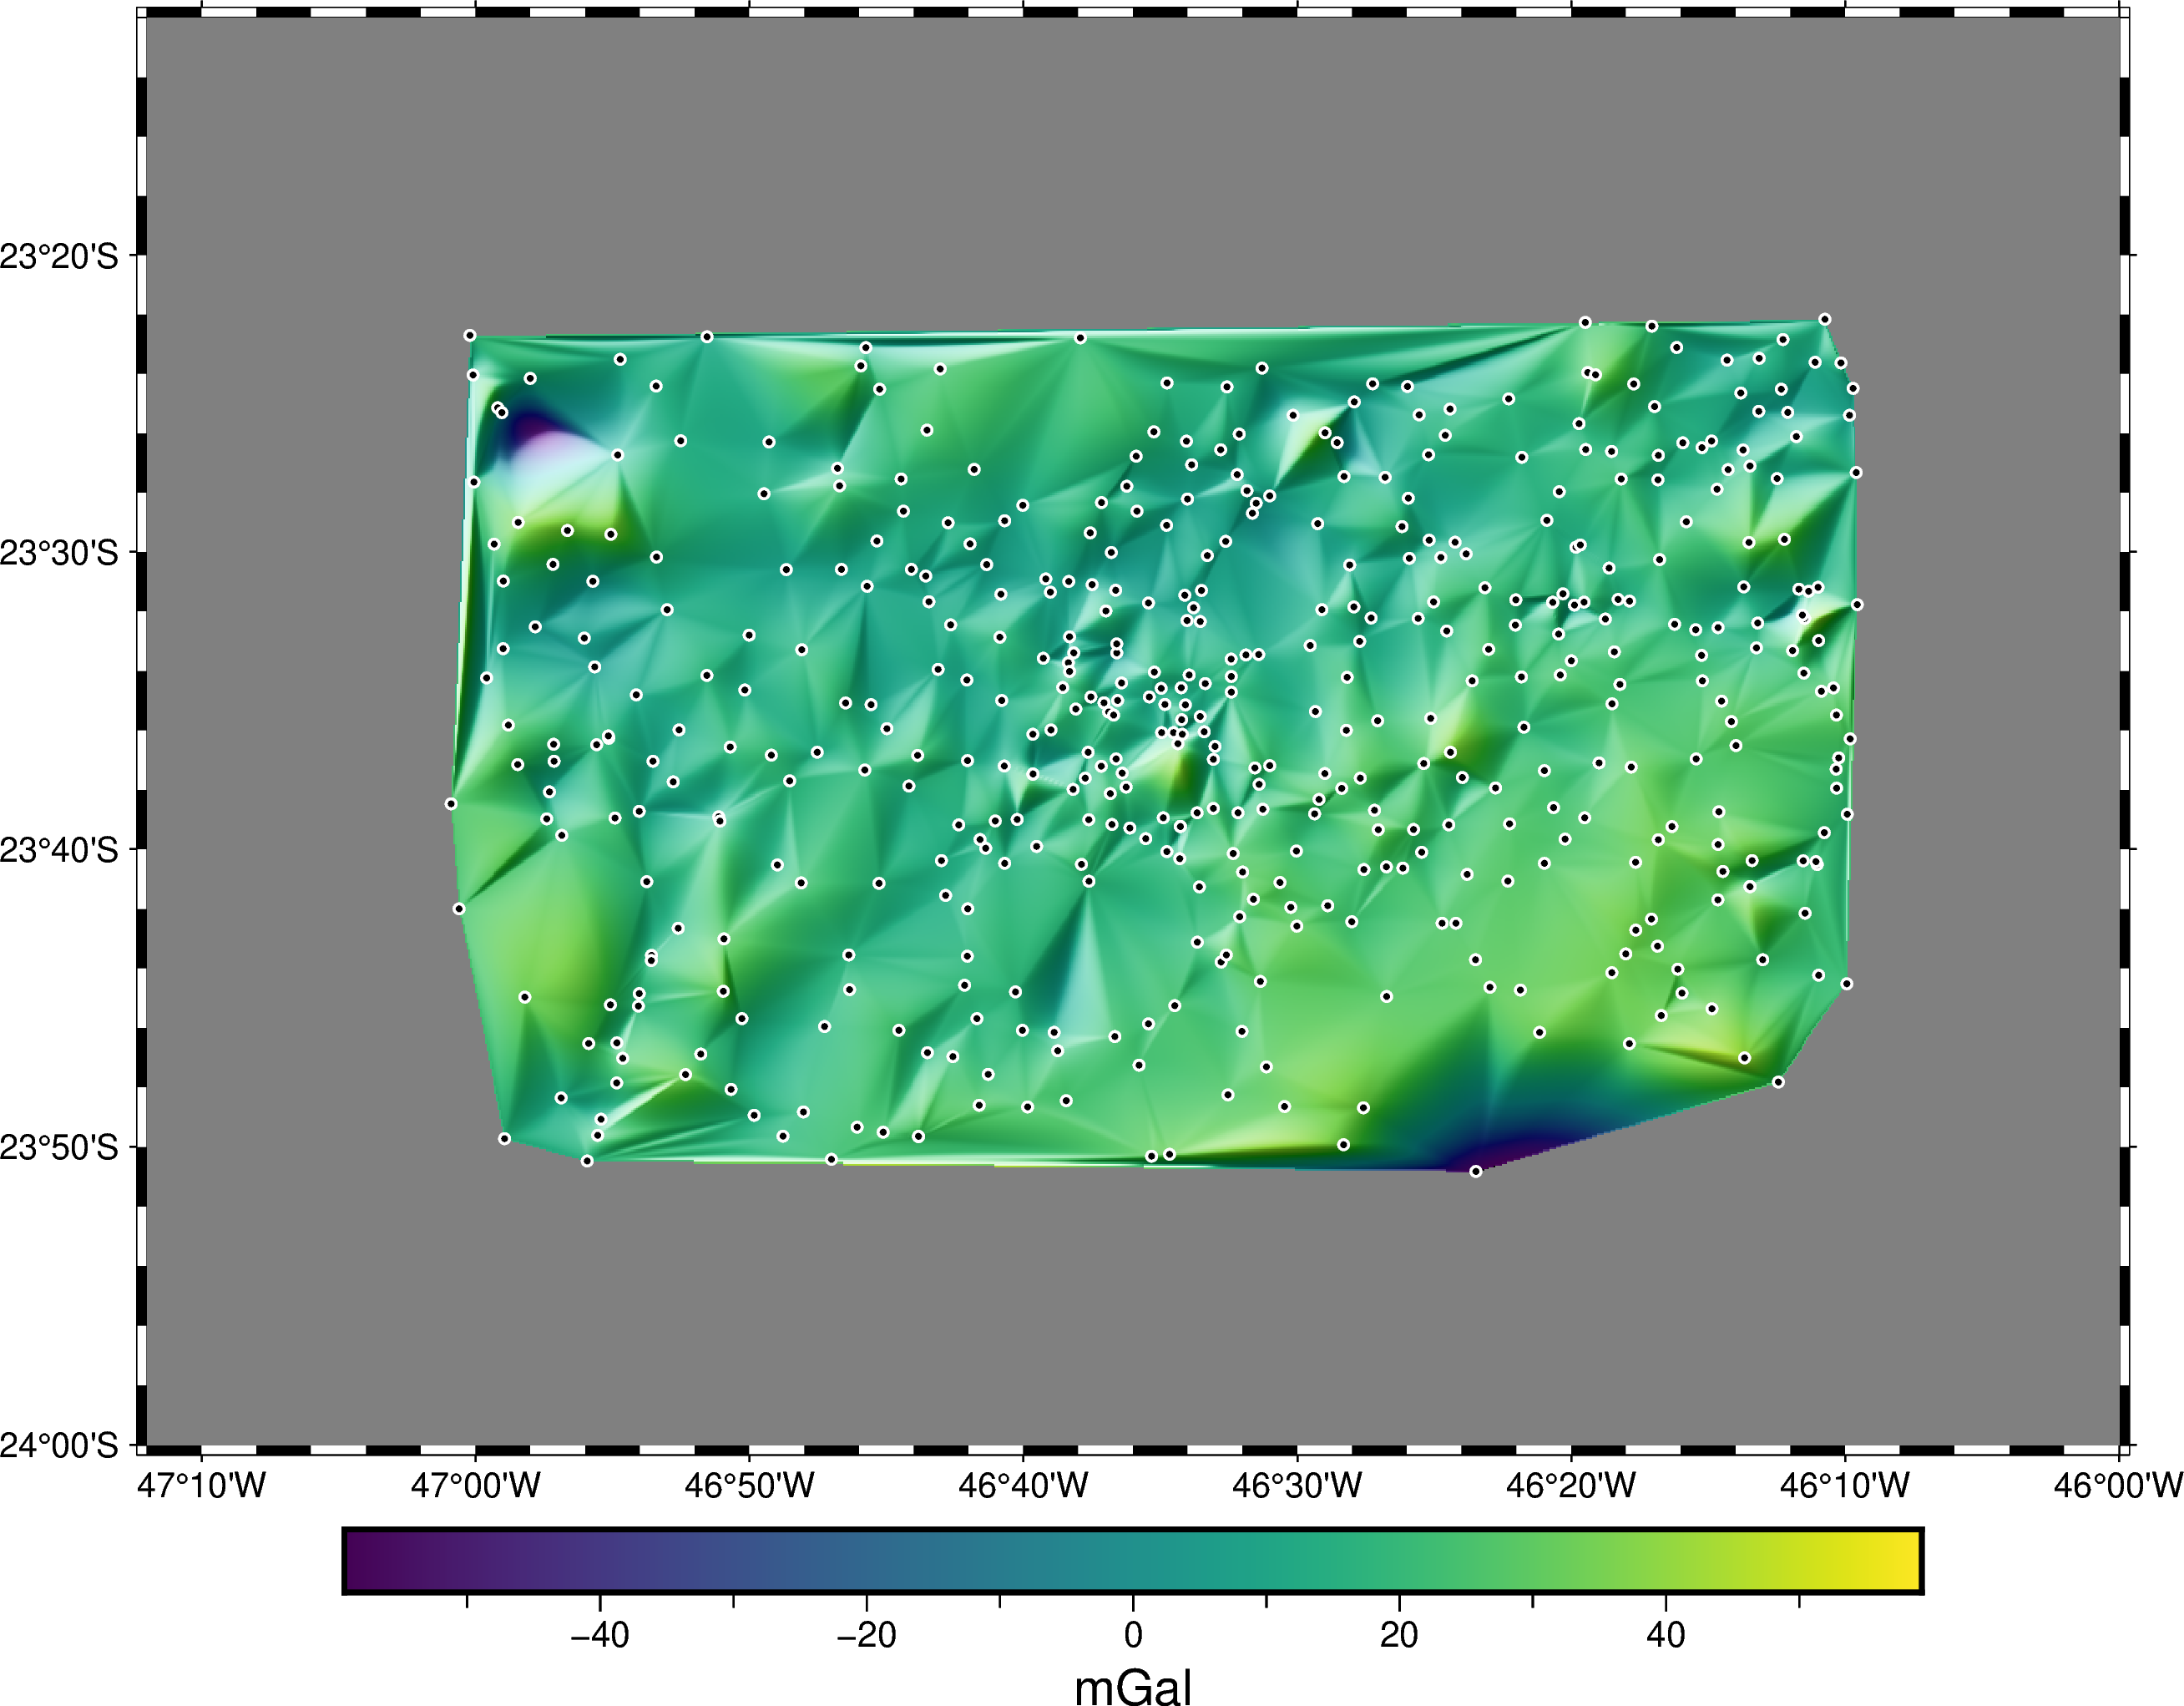

In [17]:
lon = df["longitude"].values
lat = df["latitude"].values
anomalia = df["free air"].values

region = [-47.2, -46, -24, -23.2]


interpolador = vd.Cubic().fit((lon, lat), anomalia)

grid = interpolador.grid(
   region=region,
   spacing=0.001,
   data_names="free_air"
)


fig = pygmt.Figure()

fig.coast(
   region=region,
   projection="M20c",
   frame="afg",
   land="gray"
)


max_abs_anomaly = vd.maxabs(anomalia)
pygmt.makecpt(cmap="viridis", series=[-max_abs_anomaly, max_abs_anomaly])

fig.grdimage(
   grid=grid.free_air,
   cmap=True,
   shading=True
)

fig.plot(
   x=lon,
   y=lat,
   style="c0.1c",
   fill="black",
   pen="thin,white"
)

fig.colorbar(frame="xaf+lmGal", position="JBC")

fig.show(width=600)